# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Loading the dataset

In [2]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()

In [3]:
x_data= np.concatenate((x_train, x_test), axis=0)
y_data= np.concatenate((y_train, y_test), axis=0)

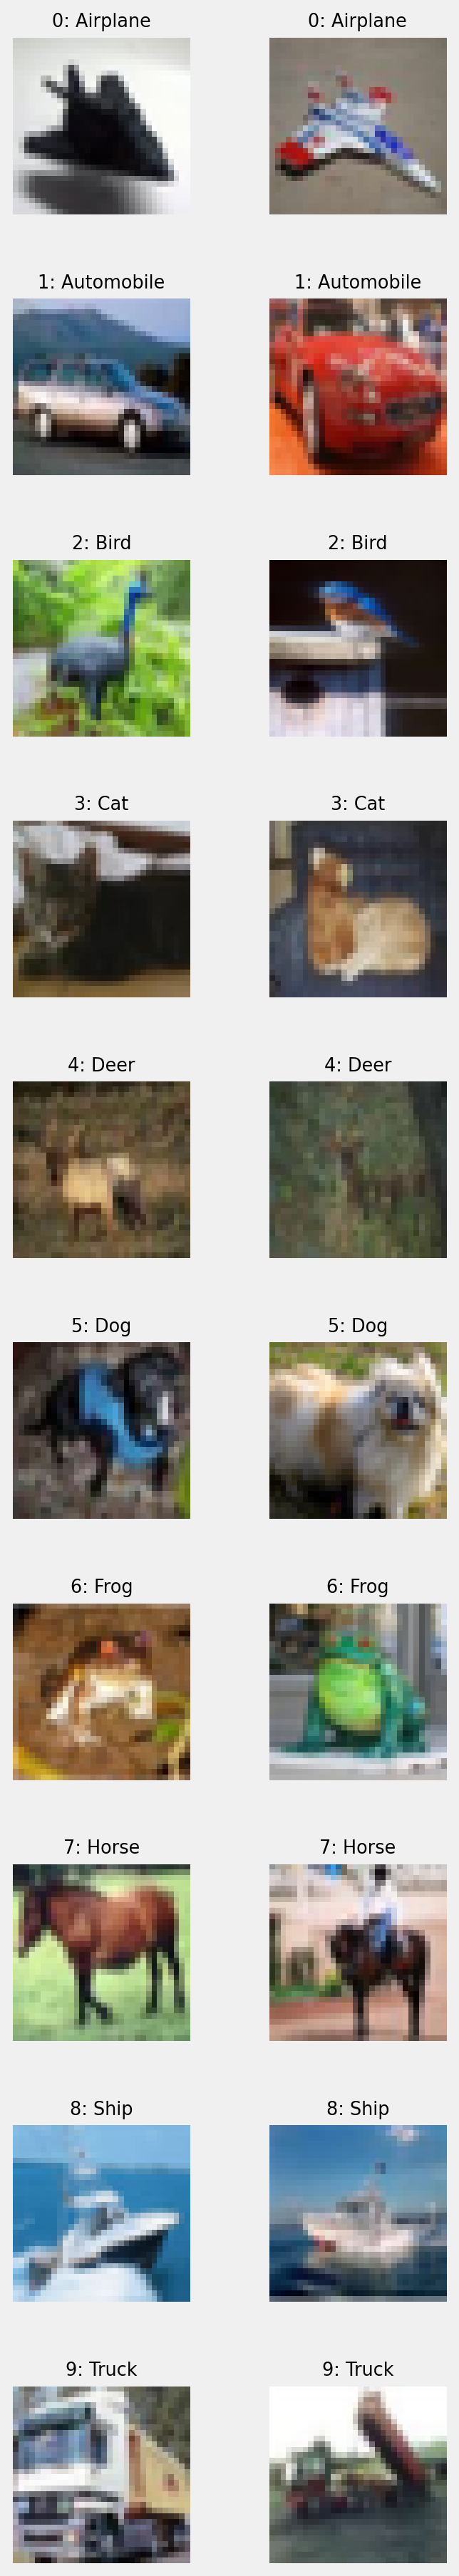

In [40]:
# CIFAR-10 class names
class_names= [
    "Airplane", "Automobile", "Bird", "Cat", 
    "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Create a dictionary to store two examples for each class
examples= {class_id : [] for class_id in range(10)}

# Loop through the data and collect two examples per class
for i in range(len(y_data)):
    class_id= y_data[i][0]  # Extract class index
    if len(examples[class_id]) < 2:
        examples[class_id].append(x_data[i])
    if all(len(v) == 2 for v in examples.values()):  # Stop when all classes have 2 examples
        break

# Plot the examples
plt.style.use('fivethirtyeight')
fig, axes= plt.subplots(10, 2, figsize= (4, 20), dpi= 184)
fig.tight_layout(pad= 0.48)
for class_id, rows in examples.items():
    for j, img in enumerate(rows):
        ax= axes[class_id, j]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{class_id}: {class_names[class_id]}", fontsize= 10)
plt.show()


# Step 1

selecting 10,000 data(1,000 for eace class)

In [4]:
num_per_class= 1000
num_classes= 10

selected_images= []
selected_labels= []

for class_id in range(num_classes):
    class_indices= np.where(y_data == class_id)[0]
    selected_indices= np.random.choice(class_indices, num_per_class, replace=False)
    selected_images.append(x_data[selected_indices])
    selected_labels.append(y_data[selected_indices])

selected_images= np.concatenate(selected_images, axis=0)
selected_labels= np.concatenate(selected_labels, axis=0)

print(f"Selected images shape: {selected_images.shape}")
print(f"Selected labels shape: {selected_labels.shape}")

Selected images shape: (10000, 32, 32, 3)
Selected labels shape: (10000, 1)


# Step 2

set the resolutions(32x32 and 16x16)

In [5]:
original_resolution= (32, 32)
low_resolution= (16, 16)

data_high_res= x_data.copy()

data_low_res= []
for img in x_data:
    low_res_img= Image.fromarray(img).resize(low_resolution, Image.ANTIALIAS)
    data_low_res.append(np.array(low_res_img))
data_low_res= np.array(data_low_res)

print(f"High-resolution data shape: {data_high_res.shape}")
print(f"Low-resolution data shape: {data_low_res.shape}")

C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_13796\3995905558.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  low_res_img= Image.fromarray(img).resize(low_resolution, Image.ANTIALIAS)


High-resolution data shape: (60000, 32, 32, 3)
Low-resolution data shape: (60000, 16, 16, 3)


# Step 3

spliting the dataset to train and test and validation

In [6]:
train_ratio= 0.7
val_ratio= 0.15
test_ratio= 0.15

num_samples= len(y_data)

indices= np.arange(num_samples)
np.random.shuffle(indices)

train_end= int(train_ratio * num_samples)
val_end= train_end + int(val_ratio * num_samples)

train_indices= indices[ : train_end]
val_indices= indices[train_end : val_end]
test_indices= indices[val_end : ]


x_train_high, x_val_high, x_test_high= data_high_res[train_indices], data_high_res[val_indices], data_high_res[test_indices]
x_train_low, x_val_low, x_test_low= data_low_res[train_indices], data_low_res[val_indices], data_low_res[test_indices]
y_train, y_val, y_test= y_data[train_indices], y_data[val_indices], y_data[test_indices]


print(f"High-Resolution Data Shapes: Train: {x_train_high.shape}, Validation: {x_val_high.shape}, Test: {x_test_high.shape}")
print(f"Low-Resolution Data Shapes: Train: {x_train_low.shape}, Validation: {x_val_low.shape}, Test: {x_test_low.shape}")
print(f"Labels Shapes: Train: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")

High-Resolution Data Shapes: Train: (42000, 32, 32, 3), Validation: (9000, 32, 32, 3), Test: (9000, 32, 32, 3)
Low-Resolution Data Shapes: Train: (42000, 16, 16, 3), Validation: (9000, 16, 16, 3), Test: (9000, 16, 16, 3)
Labels Shapes: Train: (42000, 1), Validation: (9000, 1), Test: (9000, 1)


# Step 4

creating the CNN model

high resolution

In [7]:
def create_high_res_cnn_model():
    model= models.Sequential([
        # first layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # second layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # flatting and danse layers
        layers.Flatten(),
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax')  # 10 class output
    ])
    return model

high_res_cnn_model= create_high_res_cnn_model()

high_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics= ['accuracy']                                      # accuracy
)

high_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

low resolution

In [8]:
def create_low_res_cnn_model():
    model= models.Sequential([
        # first layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (16, 16, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # second layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # third layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # flatting and danse layers
        layers.Flatten(),
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax') # 10 class output
    ])
    return model

low_res_cnn_model= create_low_res_cnn_model()

low_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics= ['accuracy']                                      # accuracy
)

low_res_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

# Step 5

learning rate and optimizer

high resolution

In [9]:
high_res_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

low resolution

In [10]:
low_res_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

# Step 6

learning

high resolution

In [41]:
#normalization
x_train_high= x_train_high / 255.0
x_val_high= x_val_high / 255.0
x_test_high= x_test_high / 255.0

print("Training on high-resolution data...")
history_high= high_res_cnn_model.fit(
    x_train_high, y_train,
    validation_data= (x_val_high, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on high-resolution test data...")
test_loss_high, test_acc_high= high_res_cnn_model.evaluate(x_test_high, y_test)
print(f"Test Accuracy (High-Resolution): {test_acc_high:.4f}")

Training on high-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 122s 144ms/step - accuracy: 0.3341 - loss: 1.9309 - val_accuracy: 0.4752 - val_loss: 1.4919
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 144s 152ms/step - accuracy: 0.5123 - loss: 1.3566 - val_accuracy: 0.4339 - val_loss: 1.8099
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 98s 149ms/step - accuracy: 0.5992 - loss: 1.1267 - val_accuracy: 0.6507 - val_loss: 1.0125
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 142s 148ms/step - accuracy: 0.6602 - loss: 0.9759 - val_accuracy: 0.6734 - val_loss: 0.9512
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 99s 151ms/step - accuracy: 0.6905 - loss: 0.8945 - val_accuracy: 0.5393 - val_loss: 1.4616
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 141s 149ms/step - accuracy: 0.7201 - loss: 0.8009 - val_accuracy: 0.7061 - val_loss: 0.8728
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 101s 154ms/step - accuracy: 0.7525 - loss: 0.7221 - val_accuracy: 0.7120 - val_loss: 0.8528
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14

low resolution

In [42]:
#normalization
x_train_low= x_train_low / 255.0
x_val_low= x_val_low / 255.0
x_test_low= x_test_low / 255.0

print("Training on low-resolution data...")
history_low= low_res_cnn_model.fit(
    x_train_low, y_train,
    validation_data= (x_val_low, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on low-resolution test data...")
test_loss_low, test_acc_low = low_res_cnn_model.evaluate(x_test_low, y_test)
print(f"Test Accuracy (Low-Resolution): {test_acc_low:.4f}")

Training on low-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.3191 - loss: 1.9576 - val_accuracy: 0.5142 - val_loss: 1.3392
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.5000 - loss: 1.4079 - val_accuracy: 0.4849 - val_loss: 1.4347
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.5579 - loss: 1.2372 - val_accuracy: 0.5263 - val_loss: 1.3226
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.6041 - loss: 1.1241 - val_accuracy: 0.5420 - val_loss: 1.2923
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.6349 - loss: 1.0339 - val_accuracy: 0.6227 - val_loss: 1.0627
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.6575 - loss: 0.9637 - val_accuracy: 0.6400 - val_loss: 1.0652
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.6885 - loss: 0.8900 - val_accuracy: 0.6641 - val_loss: 0.9771
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step -

# Step 7

visualization

In [43]:
plt.style.use('fivethirtyeight')
def plot_metrics(history, title_prefix):
    epochs= range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize= (14, 4))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label= 'Training Loss')
    plt.plot(epochs, history.history['val_loss'], label= 'Validation Loss')
    plt.title(f'{title_prefix} Loss per Epoch', fontsize= 14)
    plt.xlabel('Epochs', fontsize= 10)
    plt.ylabel('Loss', fontsize= 10)
    plt.legend(fontsize= 8)
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label= 'Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label= 'Validation Accuracy')
    plt.title(f'{title_prefix} Accuracy per Epoch', fontsize= 14)
    plt.xlabel('Epochs', fontsize= 10)
    plt.ylabel('Accuracy', fontsize= 10)
    plt.legend(fontsize= 8)
    
    plt.show()

high resolution

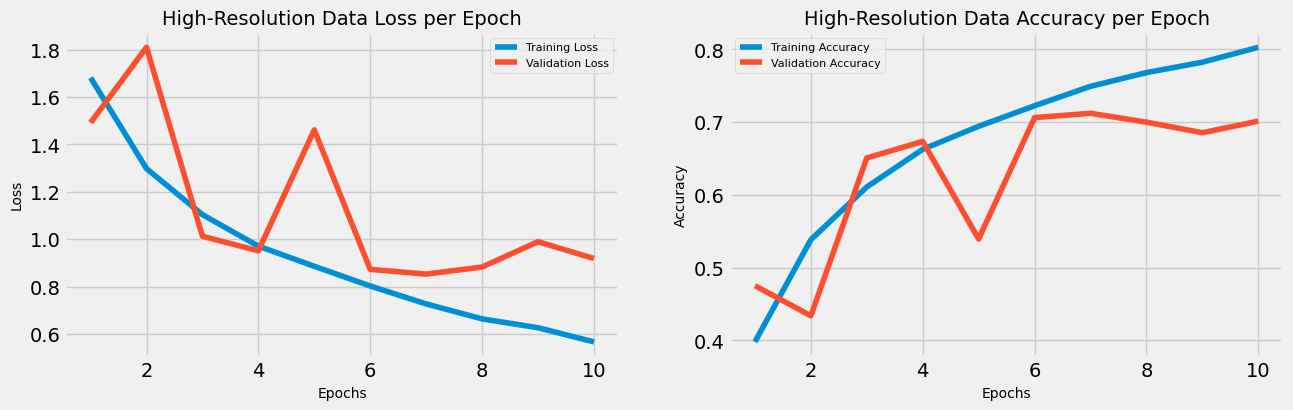

In [44]:
plot_metrics(history_high, "High-Resolution Data")

low resolution

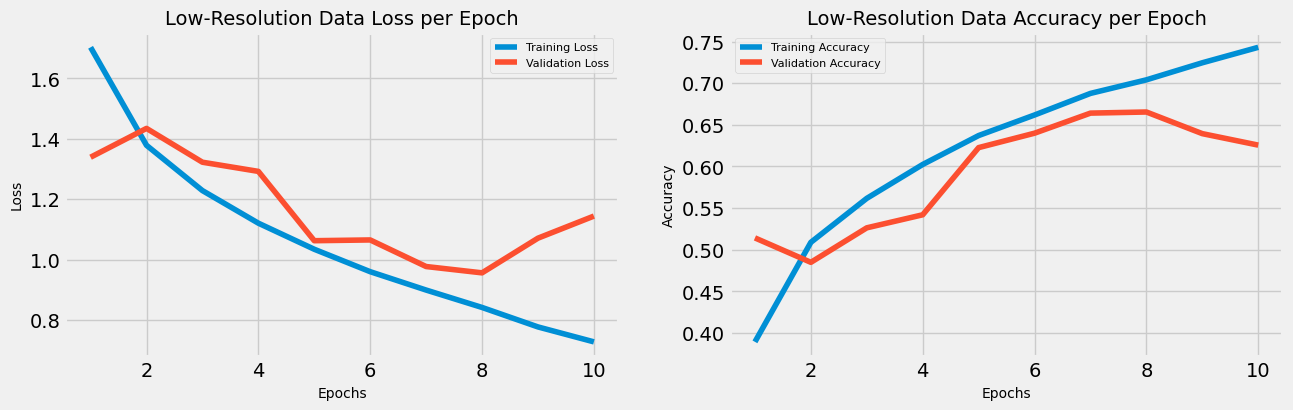

In [45]:
plot_metrics(history_low, "Low-Resolution Data")

# Step 8

confusion matrix

high resolution

In [46]:
y_pred_high= np.argmax(high_res_cnn_model.predict(x_test_high), axis= 1)
conf_matrix_high= confusion_matrix(y_test, y_pred_high)

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


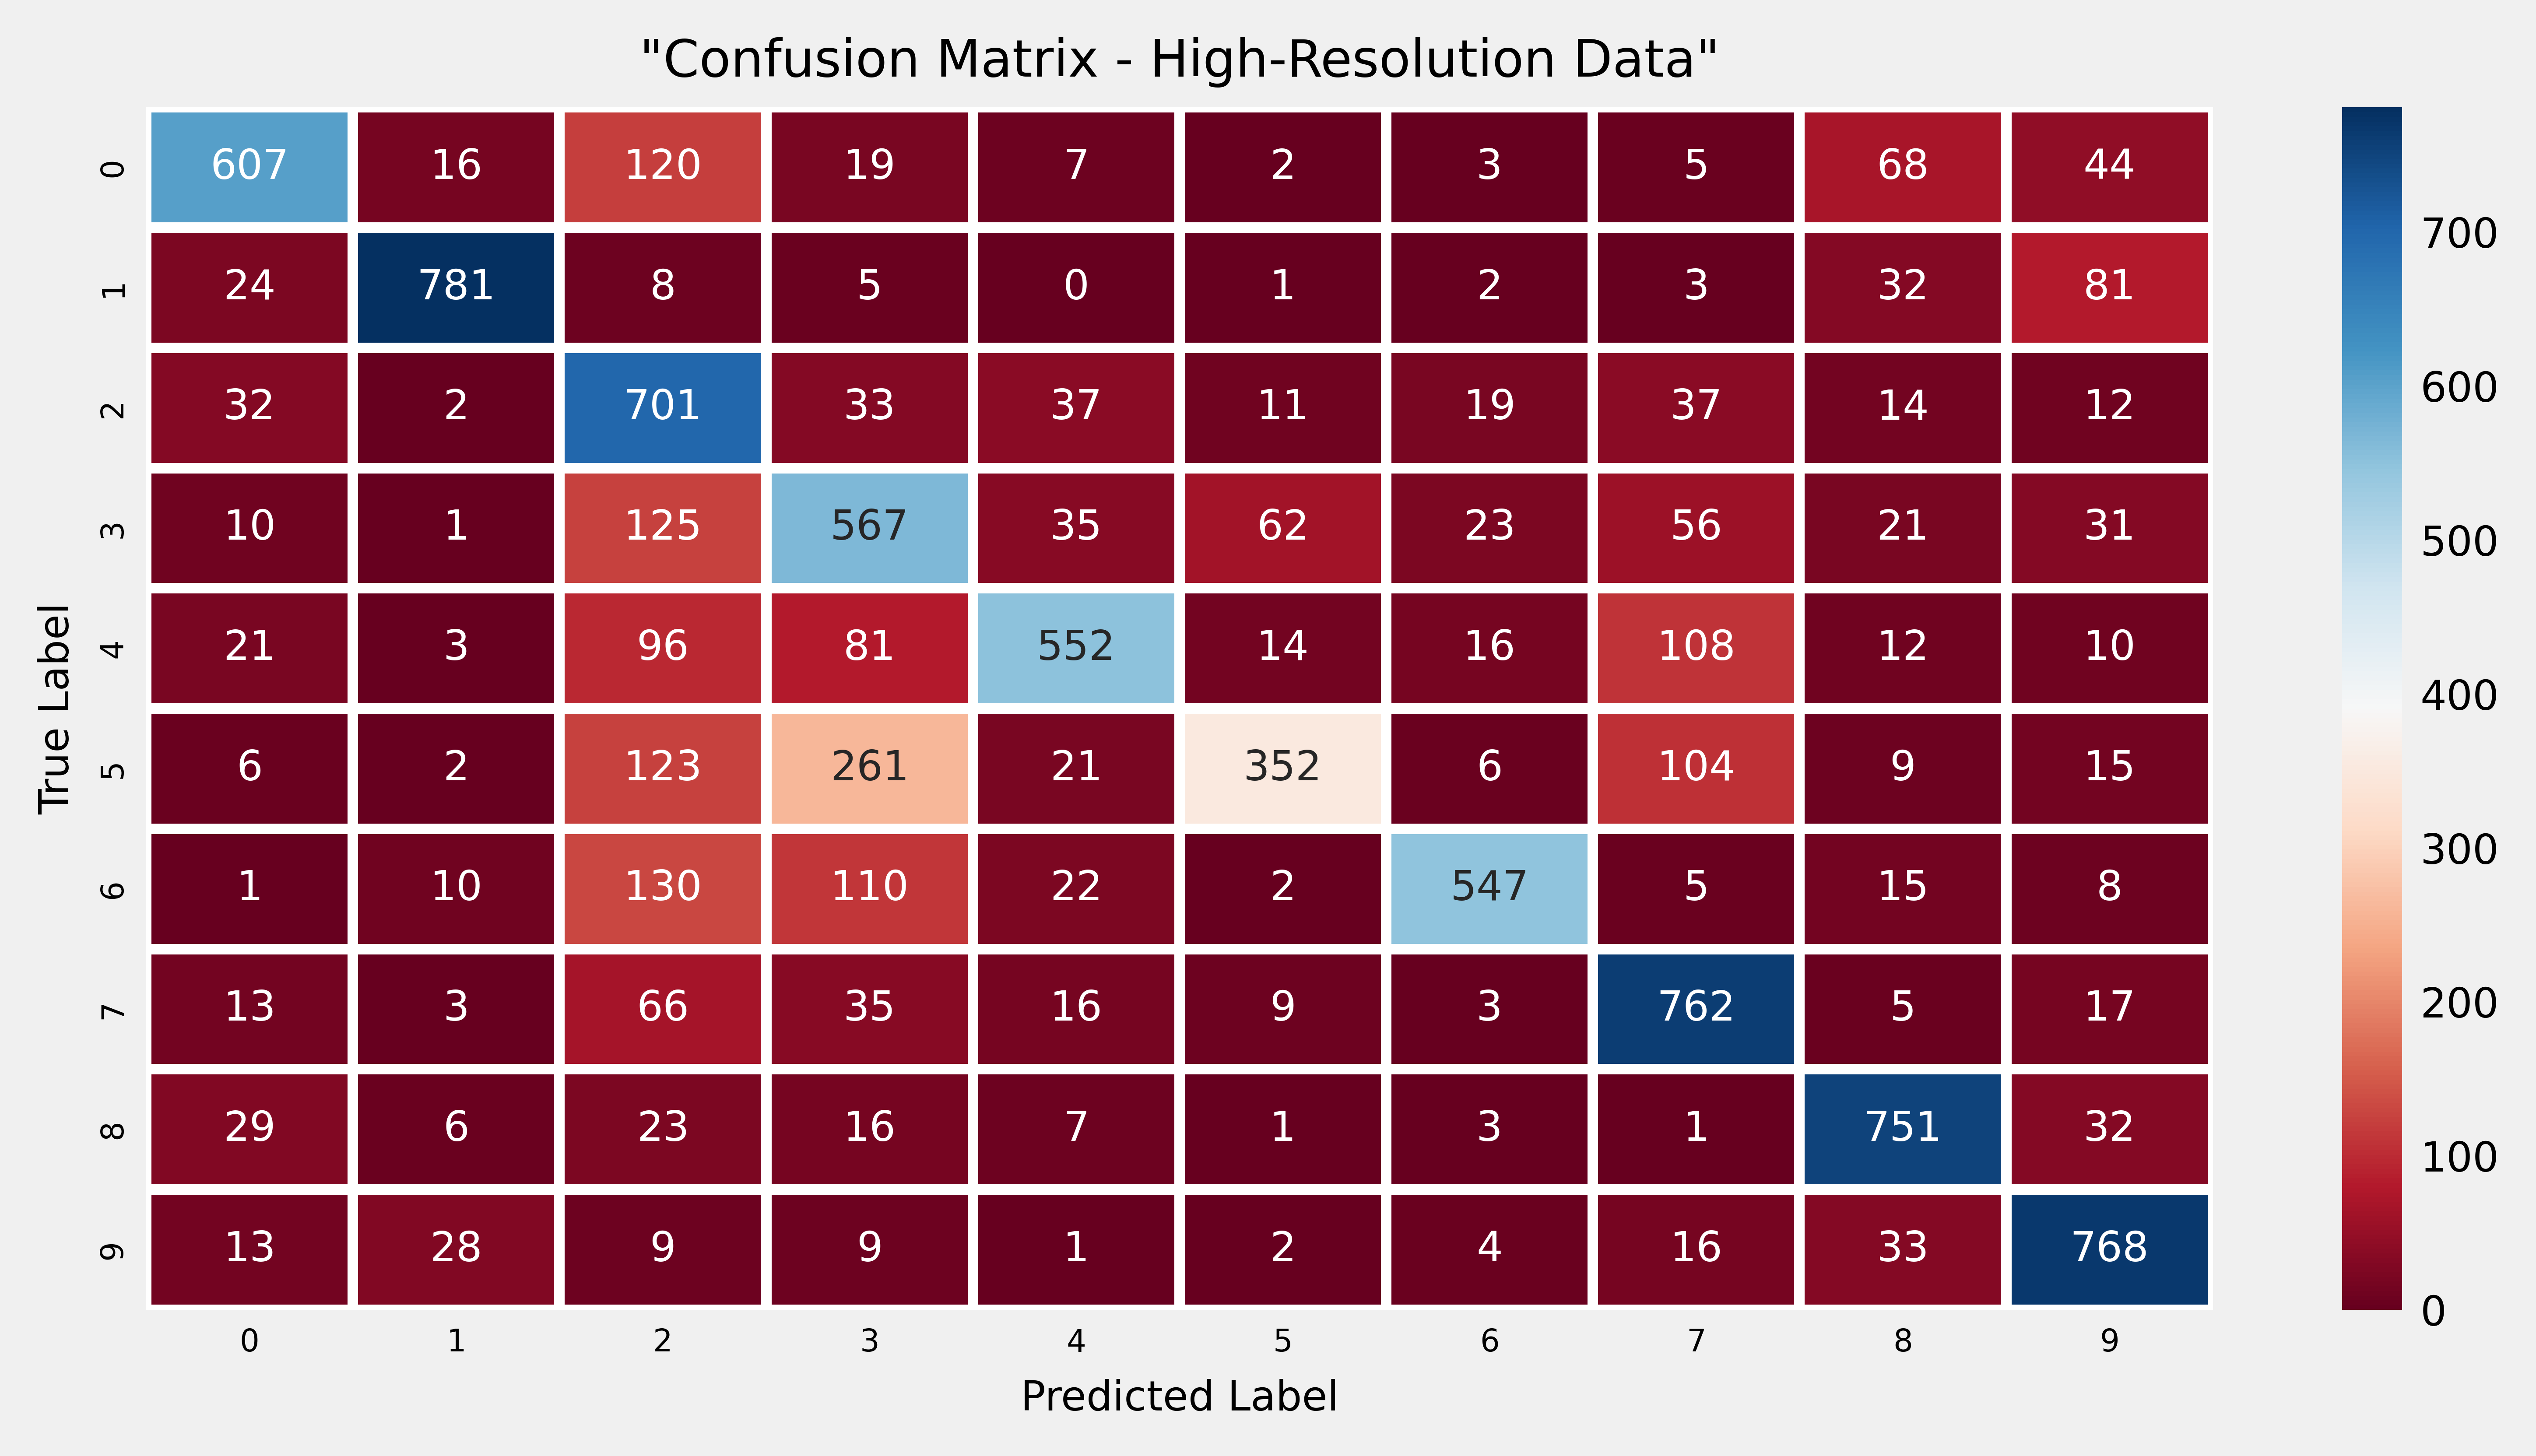

In [47]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_high, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - High-Resolution Data"', fontsize= 10);

low resolution

In [48]:
y_pred_low= np.argmax(low_res_cnn_model.predict(x_test_low), axis=1)
conf_matrix_low= confusion_matrix(y_test, y_pred_low)

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


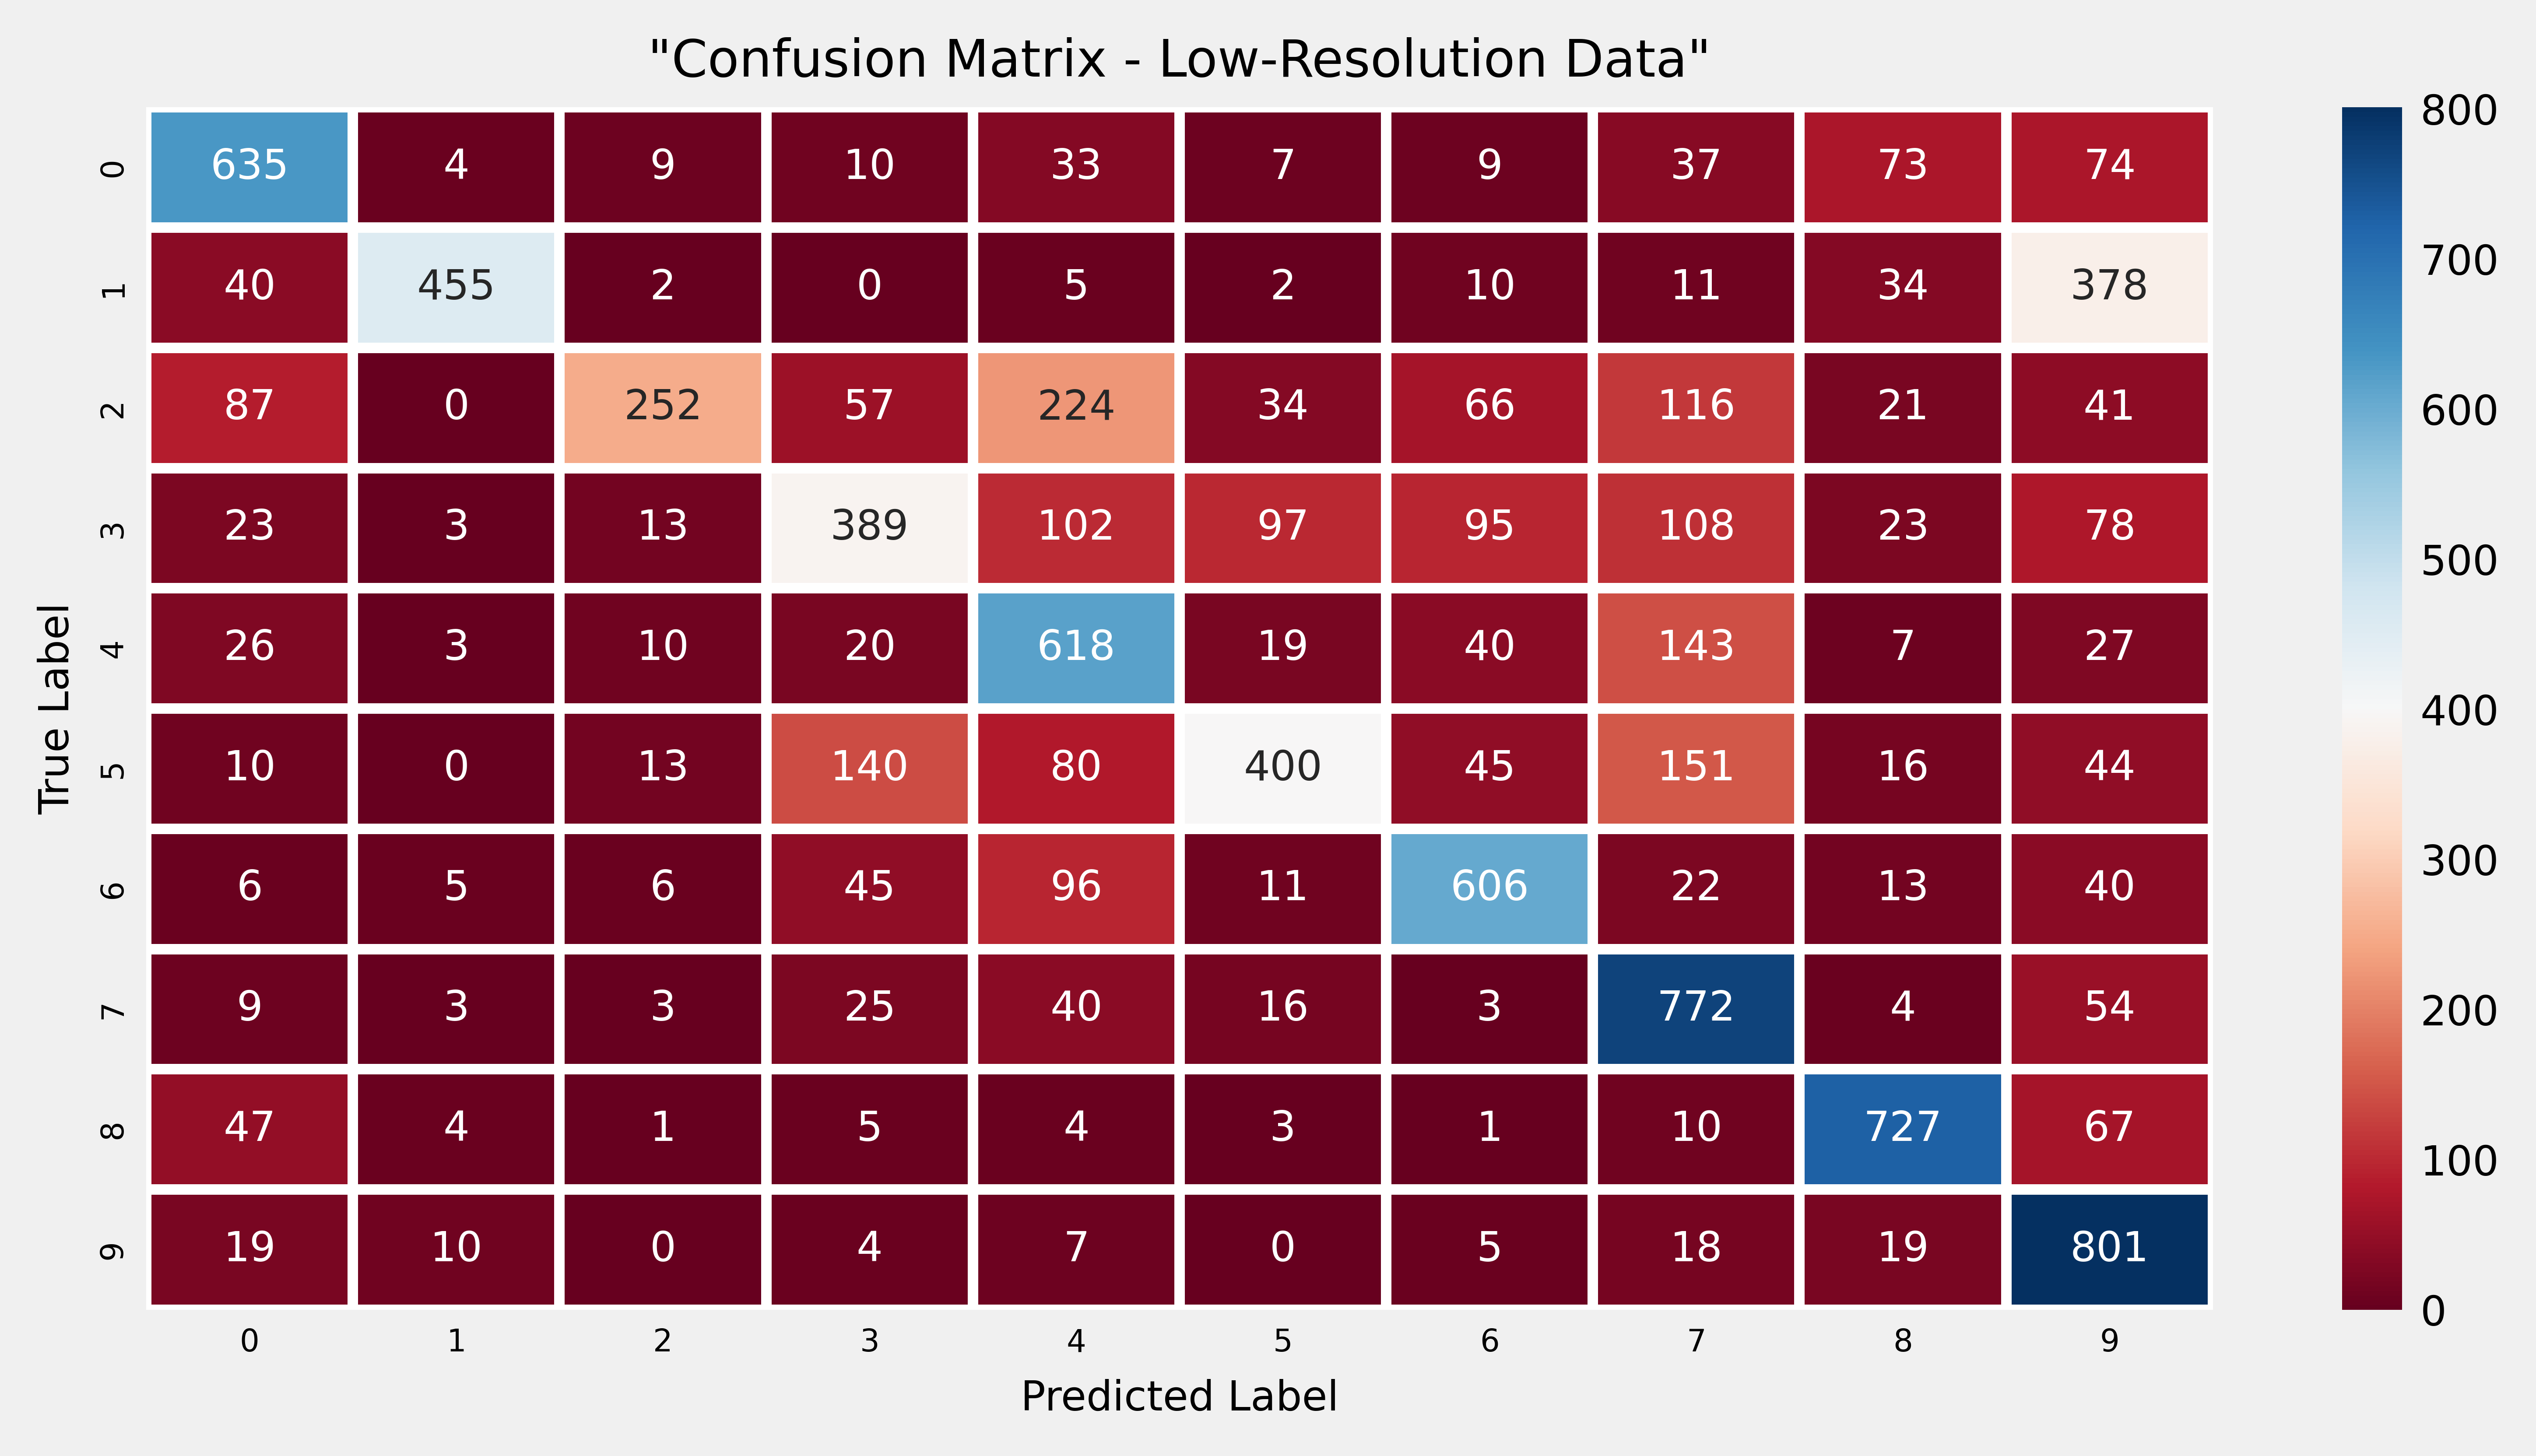

In [ ]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_low, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - Low-Resolution Data"', fontsize= 10);

# Step 4 ... 8 for a general CNN model

creating the model

In [57]:
def create_general_cnn_model():
    model= models.Sequential([
        # first convolutional layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (None, None, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # second convolutional layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third convolutional layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # global average pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # fully connected layers
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax')  # 10-class output
    ])
    return model

# "high resolution"

In [58]:
# create the model
general_high_res_cnn_model= create_general_cnn_model()

# compile the model
general_high_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics=['accuracy']                                      # metrics
)

# model summary
general_high_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

training

In [59]:
print("Training on high-resolution data...")
history_high_general= general_high_res_cnn_model.fit(
    x_train_high, y_train,
    validation_data= (x_val_high, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on high-resolution test data...")
test_loss_high_general, test_acc_high_general= general_high_res_cnn_model.evaluate(x_test_high, y_test)
print(f"Test Accuracy (High-Resolution): {test_acc_high_general:.4f}")

Training on high-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 147s 181ms/step - accuracy: 0.3584 - loss: 1.7792 - val_accuracy: 0.5227 - val_loss: 1.3119
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 129s 164ms/step - accuracy: 0.5647 - loss: 1.2086 - val_accuracy: 0.5060 - val_loss: 1.5267
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 98s 149ms/step - accuracy: 0.6381 - loss: 1.0264 - val_accuracy: 0.6392 - val_loss: 1.0128
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 99s 151ms/step - accuracy: 0.6776 - loss: 0.9192 - val_accuracy: 0.5384 - val_loss: 1.2875
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 101s 154ms/step - accuracy: 0.7126 - loss: 0.8259 - val_accuracy: 0.6454 - val_loss: 1.0336
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 139s 148ms/step - accuracy: 0.7356 - loss: 0.7653 - val_accuracy: 0.6954 - val_loss: 0.8888
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 100s 152ms/step - accuracy: 0.7549 - loss: 0.7066 - val_accuracy: 0.7066 - val_loss: 0.8541
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14

visualization

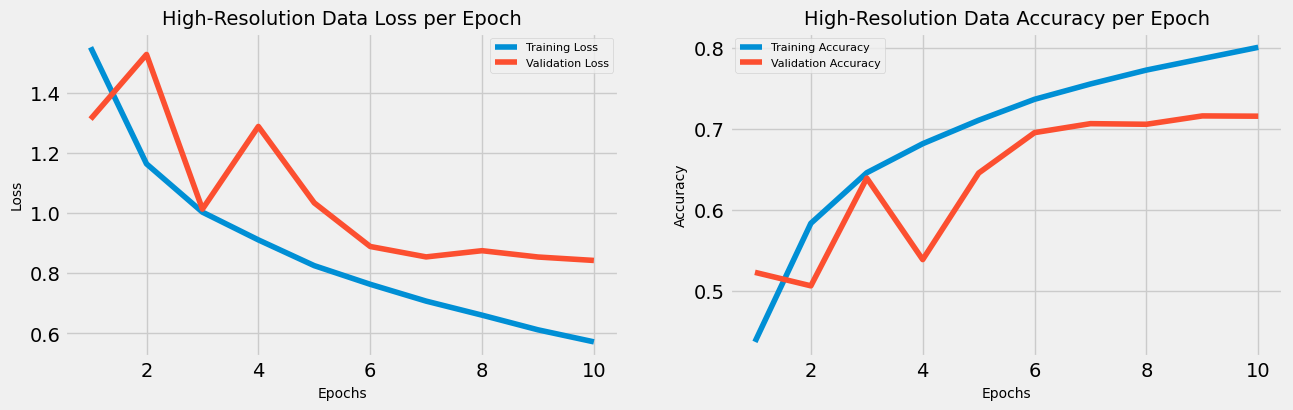

In [60]:
plot_metrics(history_high_general, "High-Resolution Data")

confusion matrix

In [61]:
y_pred_high_general= np.argmax(general_high_res_cnn_model.predict(x_test_high), axis= 1)
conf_matrix_high_general= confusion_matrix(y_test, y_pred_high_general)

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


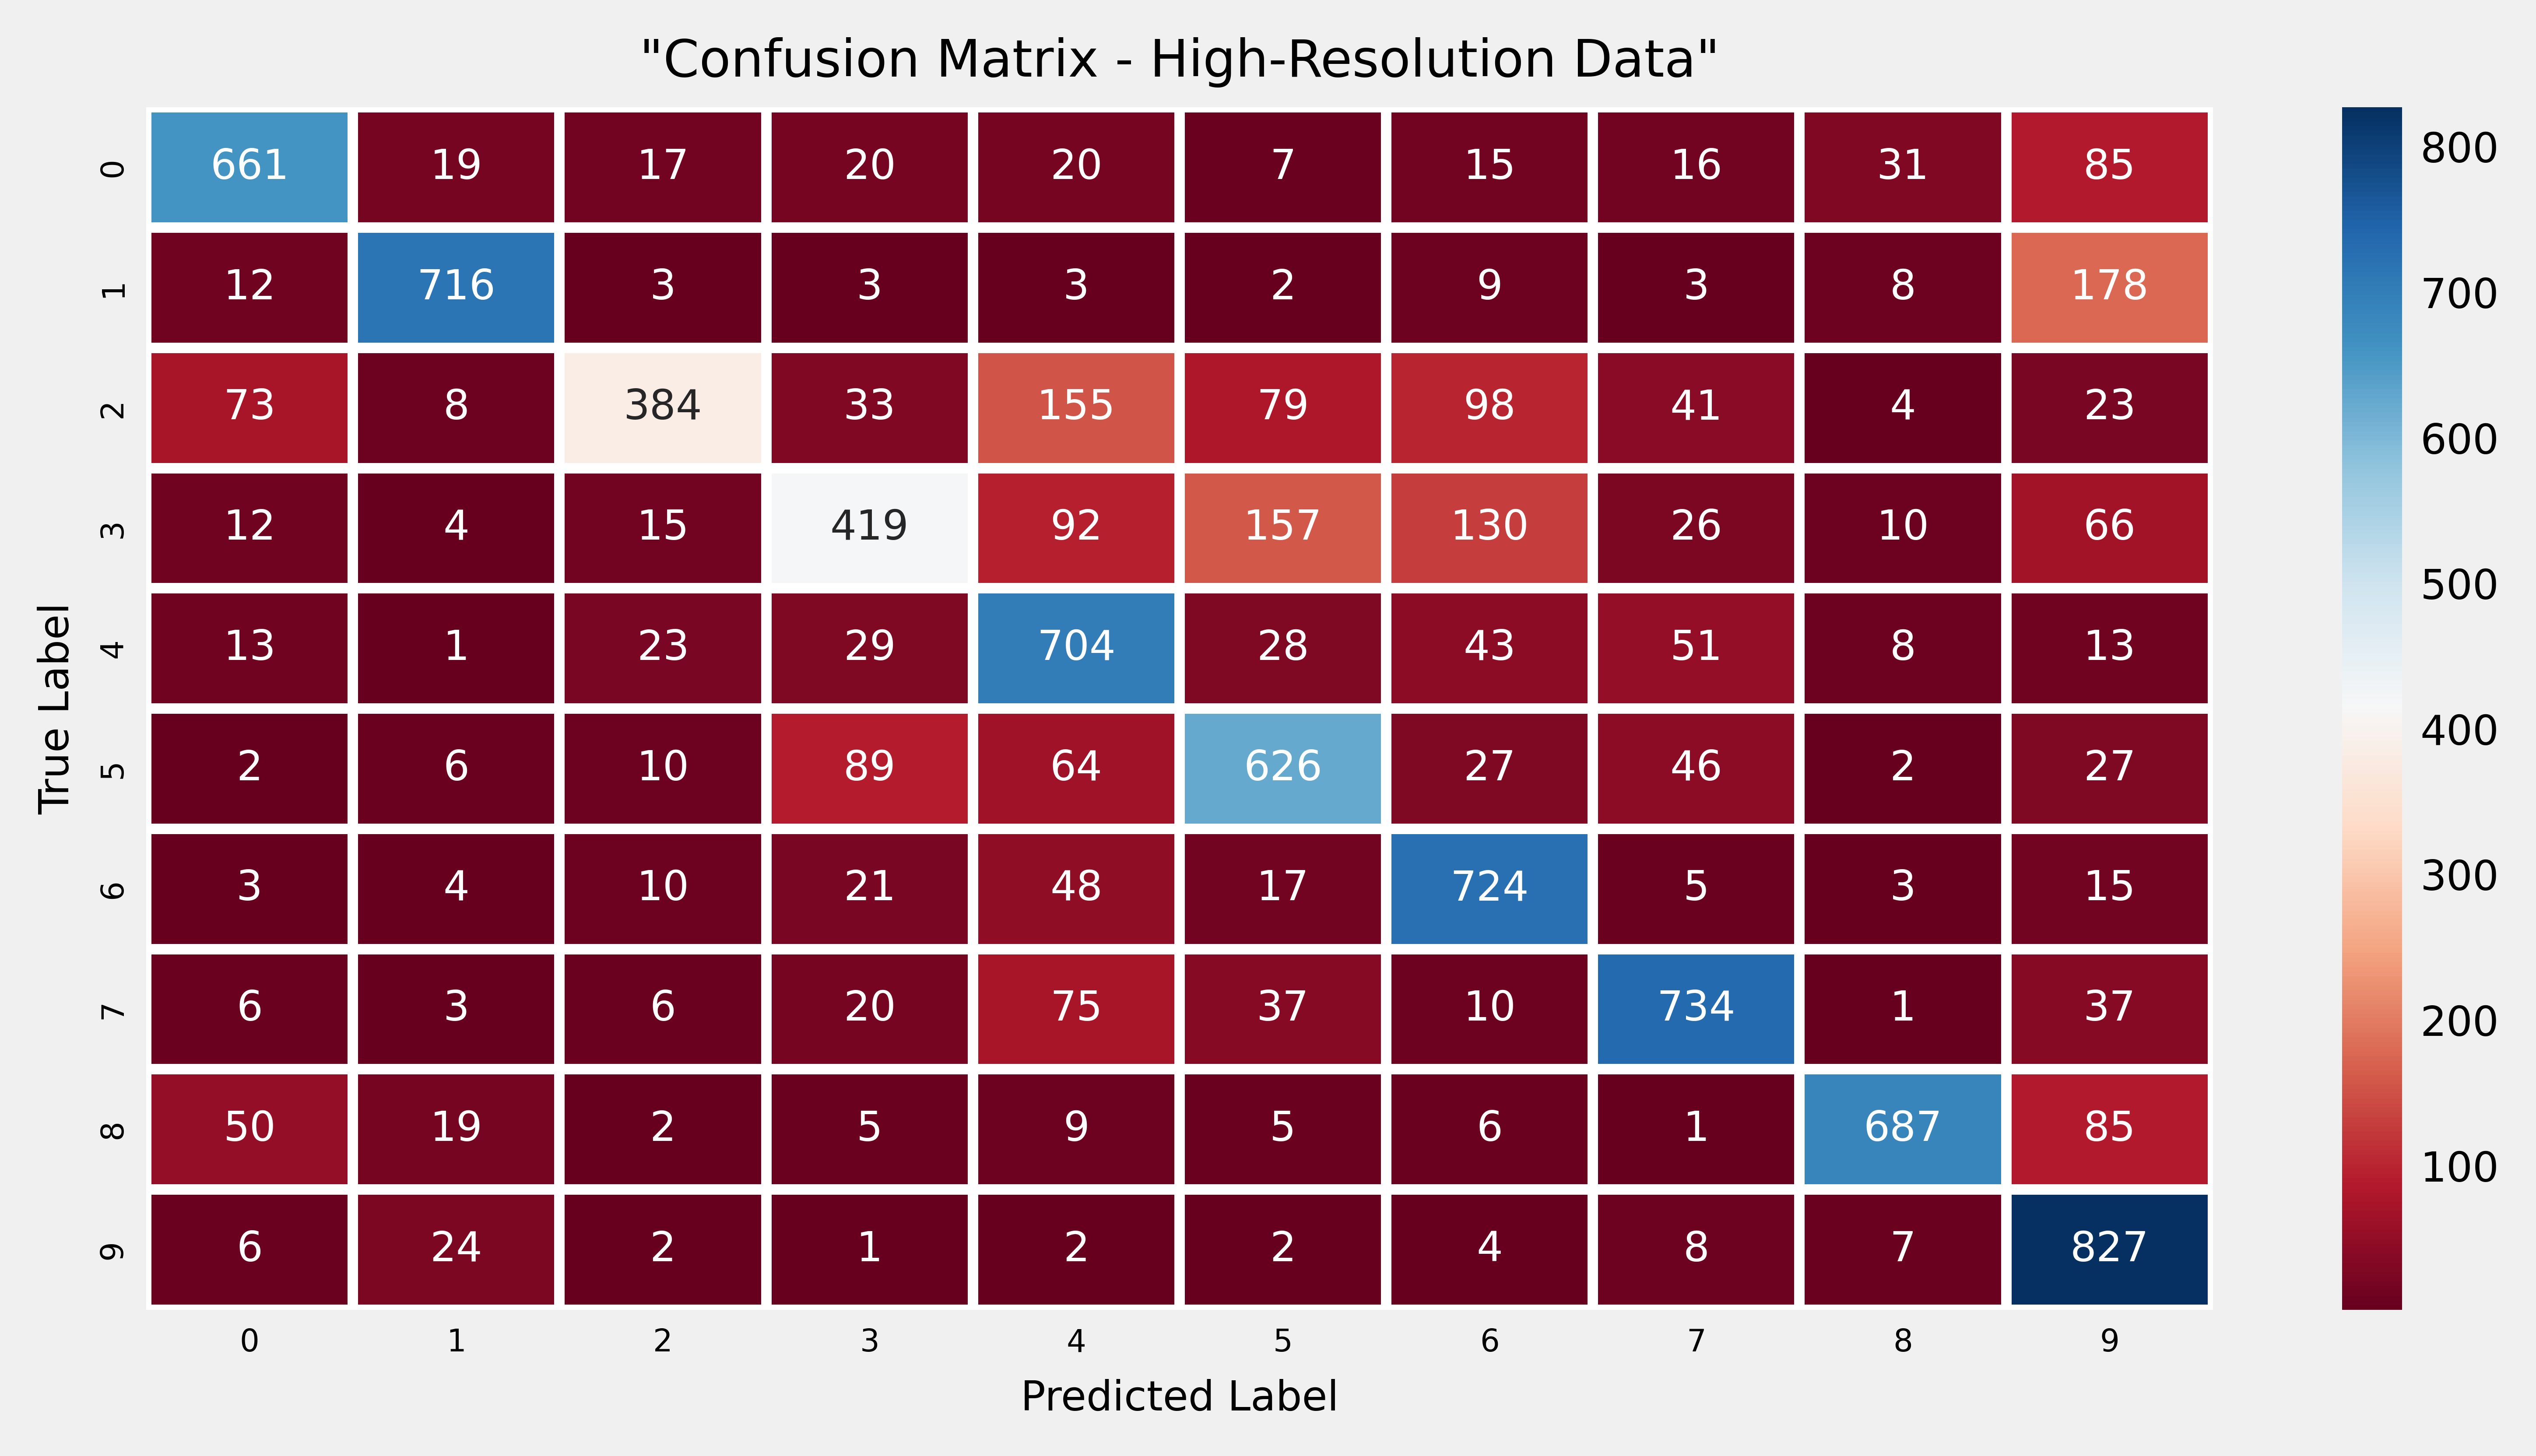

In [62]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_high_general, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - High-Resolution Data"', fontsize= 10);

# "low resolution"

In [63]:
# create the model
general_low_res_cnn_model= create_general_cnn_model()

# compile the model
general_low_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics=['accuracy']                                      # metrics
)

# model summary
general_low_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

training

In [64]:
print("Training on low-resolution data...")
history_low_general= general_low_res_cnn_model.fit(
    x_train_low, y_train,
    validation_data= (x_val_low, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on low-resolution test data...")
test_loss_low_general, test_acc_low_general= general_low_res_cnn_model.evaluate(x_test_low, y_test)
print(f"Test Accuracy (Low-Resolution): {test_acc_low_general:.4f}")

Training on low-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.3486 - loss: 1.8433 - val_accuracy: 0.4853 - val_loss: 1.4143
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.5310 - loss: 1.3155 - val_accuracy: 0.4891 - val_loss: 1.3837
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5849 - loss: 1.1597 - val_accuracy: 0.5873 - val_loss: 1.1571
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6200 - loss: 1.0709 - val_accuracy: 0.5850 - val_loss: 1.1722
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6560 - loss: 0.9767 - val_accuracy: 0.5458 - val_loss: 1.2991
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.6878 - loss: 0.8973 - val_accuracy: 0.6464 - val_loss: 1.0036
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.7069 - loss: 0.8363 - val_accuracy: 0.5907 - val_loss: 1.2017
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step -

visualization

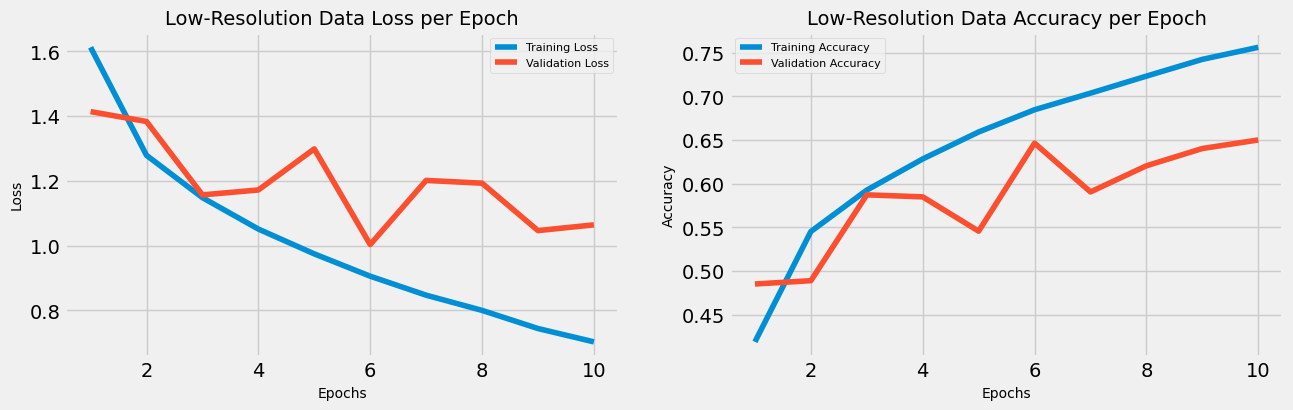

In [65]:
plot_metrics(history_low_general, "Low-Resolution Data")

confusion matrix

In [66]:
y_pred_low_general= np.argmax(general_low_res_cnn_model.predict(x_test_low), axis= 1)
conf_matrix_low_general= confusion_matrix(y_test, y_pred_high_general)

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


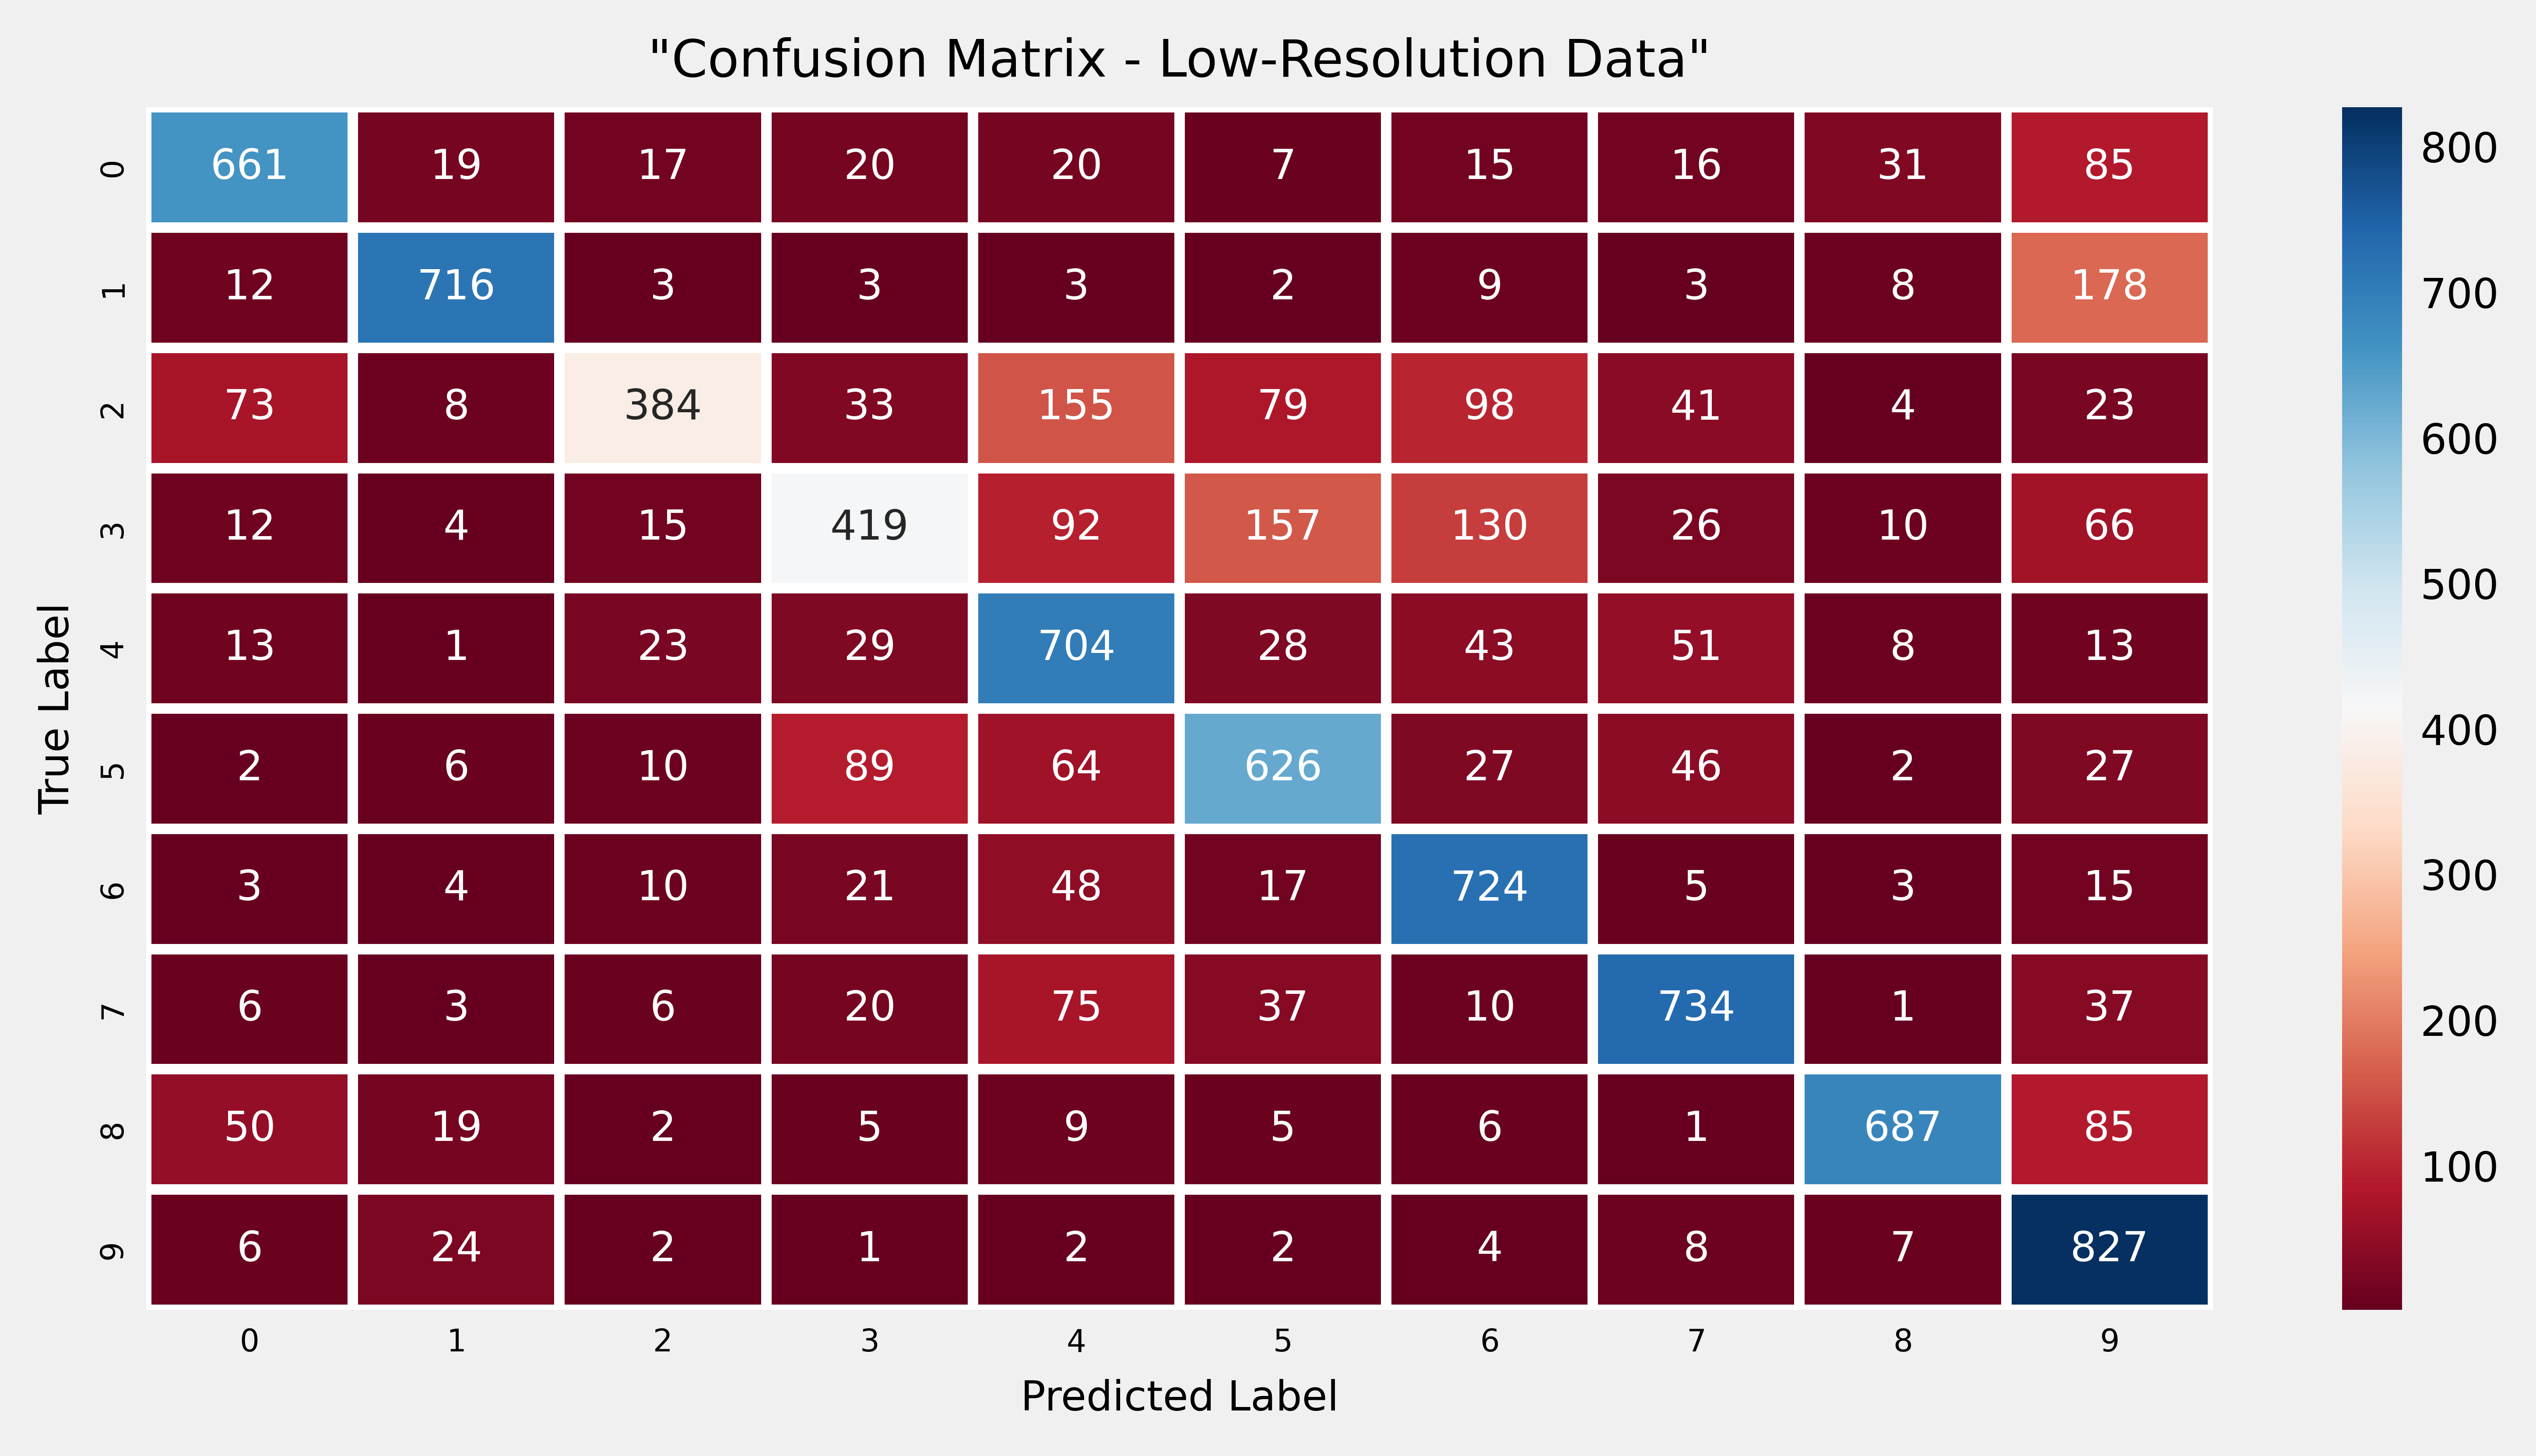

In [67]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_low_general, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - Low-Resolution Data"', fontsize= 10);

# Step 9

accuracy, precision, f1

a

In [69]:
y_pred_high_on_high= np.argmax(general_high_res_cnn_model.predict(x_test_high), axis= 1)
accuracy_high_on_high= accuracy_score(y_test, y_pred_high_on_high)
precision_high_on_high= precision_score(y_test, y_pred_high_on_high, average= 'weighted')
f1_high_on_high= f1_score(y_test, y_pred_high_on_high, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


b

In [70]:
y_pred_high_on_low= np.argmax(general_high_res_cnn_model.predict(x_test_low), axis= 1)
accuracy_high_on_low= accuracy_score(y_test, y_pred_high_on_low)
precision_high_on_low= precision_score(y_test, y_pred_high_on_low, average= 'weighted')
f1_high_on_low= f1_score(y_test, y_pred_high_on_low, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


c

In [71]:
y_pred_low_on_high= np.argmax(general_low_res_cnn_model.predict(x_test_high), axis= 1)
accuracy_low_on_high= accuracy_score(y_test, y_pred_low_on_high)
precision_low_on_high= precision_score(y_test, y_pred_low_on_high, average= 'weighted')
f1_low_on_high= f1_score(y_test, y_pred_low_on_high, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


d

In [72]:
y_pred_low_on_low= np.argmax(general_low_res_cnn_model.predict(x_test_low), axis= 1)
accuracy_low_on_low= accuracy_score(y_test, y_pred_low_on_low)
precision_low_on_low= precision_score(y_test, y_pred_low_on_low, average= 'weighted')
f1_low_on_low= f1_score(y_test, y_pred_low_on_low, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


results

In [73]:
results= {
    "High model on High test" : (accuracy_high_on_high, precision_high_on_high, f1_high_on_high),
    "High model on Low test" : (accuracy_high_on_low, precision_high_on_low, f1_high_on_low),
    "Low model on High test" : (accuracy_low_on_high, precision_low_on_high, f1_low_on_high),
    "Low model on Low test" : (accuracy_low_on_low, precision_low_on_low, f1_low_on_low)
}

for scenario, metrics in results.items():
    print(f"{scenario}:")
    print(f"  Accuracy: {metrics[0]:.4f}")
    print(f"  Precision: {metrics[1]:.4f}")
    print(f"  F1-Score: {metrics[2]:.4f}\n")

High model on High test:
  Accuracy: 0.7202
  Precision: 0.7383
  F1-Score: 0.7149

High model on Low test:
  Accuracy: 0.3489
  Precision: 0.4192
  F1-Score: 0.3425

Low model on High test:
  Accuracy: 0.3000
  Precision: 0.5744
  F1-Score: 0.2708

Low model on Low test:
  Accuracy: 0.6654
  Precision: 0.6847
  F1-Score: 0.6643

